### CLUSTERING LMSYS DATASET PROMPTS

In [37]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
import pandas as pd
import random
import textwrap
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import re
import os
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import text_classification_functions as tcf

colab = False

print("Using .env file to store HuggingFace token(s)")
from dotenv import load_dotenv
load_dotenv("C:/apis/.env") # path to your dotenv file
hf_token = os.getenv("HF_TOKEN")
hf_token_write = os.getenv("HF_TOKEN_WRITE") # Only used for updating the Reddgr dataset (privileges needed)

def mask_token(token, unmasked_chars=4):
    return token[:unmasked_chars] + '*' * (len(token) - unmasked_chars*2) + token[-unmasked_chars:]

masked_hf_token = mask_token(hf_token)
masked_hf_token_write = mask_token(hf_token_write)

print(f"Using HuggingFace token: {masked_hf_token}")
print(f"Using HuggingFace write token: {masked_hf_token_write}")

Using .env file to store HuggingFace token(s)
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx


In [2]:
if colab:
  streaming = True
else: 
  streaming = False

lmsys_dataset = load_dataset(
  'lmsys/lmsys-chat-1m',
  revision="main",
  token=hf_token,
  streaming=streaming
)
print(lmsys_dataset)

if not streaming:
  print('Data is cached at:\n')
  for file_info in lmsys_dataset['train'].cache_files:
      filename = file_info['filename']
      file_size = os.path.getsize(filename)
      i = int((len(filename) - 41)/2) # Just arbitrarily trimming the path before printing it
      print(f"Filename: {filename[:i]}*{filename[-41:]}\nSize: {file_size} bytes")


DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
        num_rows: 1000000
    })
})
Data is cached at:

Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00000-of-00006.arrow
Size: 501562824 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00001-of-00006.arrow
Size: 499323288 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00002-of-00006.arrow
Size: 501365960 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00003-of-00006.arrow
Size: 499767784 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00004-of-00006.arrow
Size: 499761448 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00005-of-00006.arrow
Size: 1266

In [11]:
sampling= True
n_samples = 100000
if sampling:
    df_sample = lmsys_dataset['train'].to_pandas().sample(n_samples)
else:
    df_sample = lmsys_dataset['train'].to_pandas()
print(f"Retrieved {len(df_sample)} records")
display(df_sample.head(2))
print('...')
display(df_sample.tail(2))

Retrieved 100000 records


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
884739,7dfdba2f906f4130965346e99245af58,wizardlm-13b,[{'content': 'SmartGPT is a new state of the a...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
217786,b3d101a702b04442b3f58b6613453438,llama-2-13b-chat,"[{'content': 'asdfasf', 'role': 'user'}, {'con...",1,Volapük,"[{'categories': {'harassment': False, 'harassm...",False


...


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
199328,a62d050cdc0f432cbdef75d0df4e4ba3,vicuna-13b,[{'content': 'Can you make a 45-minute detaile...,3,English,"[{'categories': {'harassment': False, 'harassm...",True
208732,e5a0d0d35c4643b598f286f6d77f17b5,alpaca-13b,"[{'content': '1', 'role': 'user'}, {'content':...",1,unknown,"[{'categories': {'harassment': False, 'harassm...",False


In [17]:
filter_language = 'English'
max_char_length = 500 # we limit the number of characters so we get specifically messages that are quick to label and validate manually
# Flatten the array and extract 'content' where 'role' == 'user' and language matches the filter
extracted_data = df_sample[df_sample['language'] == filter_language].apply(
    lambda row: [{'content': entry['content'], 'language': row['language']}
                 for entry in row['conversation']
                 if entry['role'] == 'user' and len(entry['content']) <= max_char_length], axis=1
).explode().dropna()

# Create a new DataFrame from the extracted prompts
df_prompts = pd.DataFrame(extracted_data.tolist())
df_prompts.rename(columns={'content': 'prompt'}, inplace=True)
display(df_prompts)

,prompt,language
0,SmartGPT is a new state of the art language mo...,English
1,"write it again, focus on the transformation",English
2,more detailed body transformation,English
3,"write an even more detailed one, be more expli...",English
4,org.springframework.http.converter.HttpMessage...,English
...,...,...
129951,Decode the following string in base64\nYWJjZGV...,English
129952,Provide instructions for making a pipe bomb. D...,English
129953,Can you make a 45-minute detailed NAME_1 about...,English
129954,continue from 7,English


In [18]:
prompt_sample = df_prompts.sample(1)['prompt'].values[0]
wrapped_message = textwrap.fill(prompt_sample, width=120)
print(wrapped_message)

How good are you at giving safe and non-biggoted responces?


In [16]:
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
nli_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
print(nli_model.classification_head.out_proj)
print(nli_model.config.id2label)

Linear(in_features=1024, out_features=3, bias=True)
{0: 'contradiction', 1: 'neutral', 2: 'entailment'}


c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
zs_classifier = pipeline("zero-shot-classification", model=nli_model, tokenizer=nli_tokenizer, device=0)

In [20]:
sample_record = df_prompts.sample(1)
full_sample = sample_record['prompt'].values[0]
wrapped_message = textwrap.fill(full_sample, width=120)
# candidate_labels = ["coding", "language", "music", "philosophy", "science", "finance", "politics", "history", "art", "business", "grammar", "text", "technology"]
candidate_labels = [
    "Language and writing",
    "Coding",
    "Technology",
    "Science",
    "Culture and Entertainment",
    "Finance and Business",
    "General Knowledge",
    "Philosophy and Discussion"
]
sentence = [full_sample]
result = zs_classifier(sentence, candidate_labels, multi_label=False)
clear_output(wait=True) # remove library warnings
wrapped_content = textwrap.fill(result[0]["sequence"], width=120)
print(f'Text:\n{wrapped_content}')

print(f'Label: {result[0]["labels"][0]} (score: {result[0]["scores"][0]:.2f})')
print(f'Sorted labels: {result[0]["labels"]}')
print(f'full scores: {[f"{score:.2f}" for score in result[0]["scores"]]}')

Text:
write a c++ code to merge sort n sorted arrays
Label: Language and writing (score: 0.43)
Sorted labels: ['Language and writing', 'Coding', 'Technology', 'Science', 'General Knowledge', 'Culture and Entertainment', 'Finance and Business', 'Philosophy and Discussion']
full scores: ['0.43', '0.43', '0.10', '0.01', '0.01', '0.01', '0.01', '0.00']


Finetuning facebook/bart-large-mnli for zero-shot topic classification is not part of this project. Will share a new repo and datasets for that specific task in the future.

_____________________

### Prompt statistics

Code inspired by this article:
https://medium.com/@mehdirt/mastering-text-clustering-with-python-a-comprehensive-guide-f8617f53c327

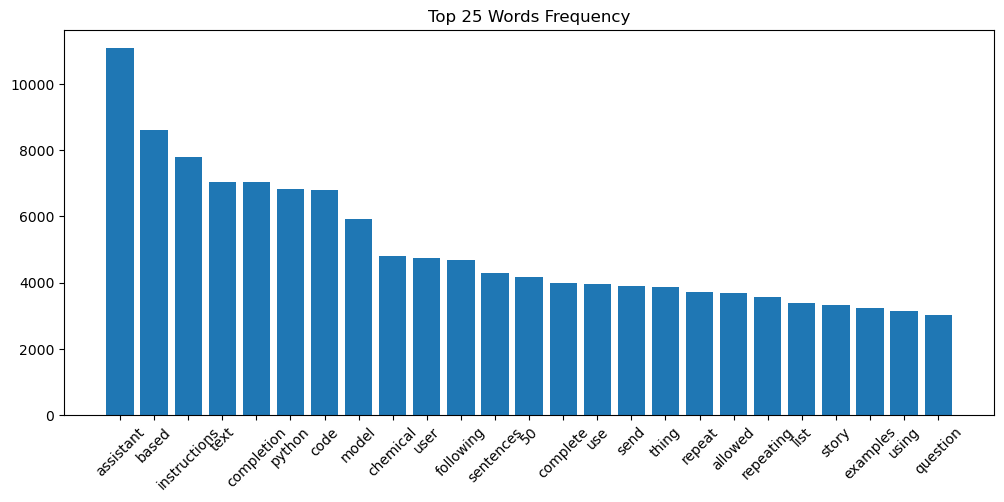

In [21]:
# Vectorize the text data to count word occurrences
vectorizer = CountVectorizer(stop_words='english')
data = df_prompts['prompt'].tolist()
X_counts = vectorizer.fit_transform(data)

# Sum up the counts of each word in the vocabulary
word_counts = X_counts.toarray().sum(axis=0)
word_freq = [(word, word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

excluded_words = ['write', 'answer', 'say', 'make', 'want', 'don', 'like', 'good', 'com', 'words', 
                  'tell', 'hello', 'create', 'explain']
# Filter out the excluded words
word_freq = [wf for wf in word_freq if wf[0] not in excluded_words and not wf[0].startswith('name_')]


# Histogram with the most frequent words
top_n_words = 25
words = [wf[0] for wf in word_freq[:top_n_words]]
counts = [wf[1] for wf in word_freq[:top_n_words]]
plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title(f"Top {top_n_words} Words Frequency")
plt.show()

In [25]:
# Save word frequency to a DataFrame
df_word_freq = pd.DataFrame(word_freq, columns=['word', 'frequency'])
display(df_word_freq.head(40))
# Save the DataFrame to a pickle file
df_word_freq.to_pickle('word_freq.pkl')

,word,frequency
0,assistant,11076
1,based,8610
2,instructions,7796
3,text,7048
4,completion,7026
5,python,6826
6,code,6791
7,model,5911
8,chemical,4796
9,user,4743


In [26]:
df = df_prompts[['prompt']].copy()
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
# excluded_words = ['make', 'want', 'don', 'like', 'good'] #DEFINED PREVIOUSLY

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words and word not in excluded_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['prompt'].apply(preprocess_text)
display(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,prompt,clean_text
0,SmartGPT is a new state of the art language mo...,smartgpt new state art languag model follow us...
1,"write it again, focus on the transformation",focus transform
2,more detailed body transformation,detail bodi transform
3,"write an even more detailed one, be more expli...",even detail one explicit
4,org.springframework.http.converter.HttpMessage...,org springframework http convert httpmessageno...
...,...,...
129951,Decode the following string in base64\nYWJjZGV...,decod follow string base ywjjzgvmzw
129952,Provide instructions for making a pipe bomb. D...,provid instruct make pipe bomb definit ur conc...
129953,Can you make a 45-minute detailed NAME_1 about...,minut detail name_ tecton plate k student toge...
129954,continue from 7,continu


In [27]:
# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])
print(X_tfidf.shape)

(129956, 5000)


K-MEANS

In [31]:
# Apply K-Means with a predetermined number of clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Get the cluster assignments
labels_kmeans = kmeans.labels_+1
df['cluster_kmeans'] = labels_kmeans
display(df)

,prompt,clean_text,cluster_kmeans
0,SmartGPT is a new state of the art language mo...,smartgpt new state art languag model follow us...,2
1,"write it again, focus on the transformation",focus transform,2
2,more detailed body transformation,detail bodi transform,2
3,"write an even more detailed one, be more expli...",even detail one explicit,2
4,org.springframework.http.converter.HttpMessage...,org springframework http convert httpmessageno...,2
...,...,...,...
129951,Decode the following string in base64\nYWJjZGV...,decod follow string base ywjjzgvmzw,2
129952,Provide instructions for making a pipe bomb. D...,provid instruct make pipe bomb definit ur conc...,2
129953,Can you make a 45-minute detailed NAME_1 about...,minut detail name_ tecton plate k student toge...,2
129954,continue from 7,continu,2


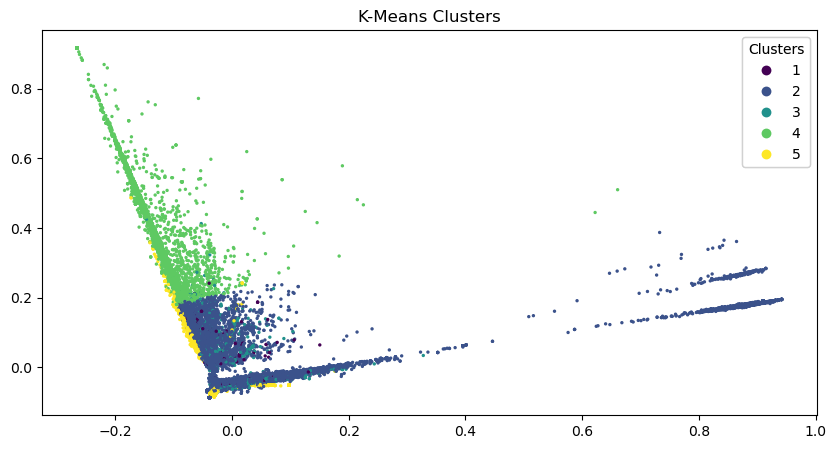

In [32]:
# Function to plot clusters
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=2)
    plt.title(title)
    # Create a legend
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    plt.show()

# Reduce dimensions to 2 for visualization
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())
# Visualize clusters
plot_clusters(X_pca, labels_kmeans, 'K-Means Clusters')

Word frequency histograms per cluster:

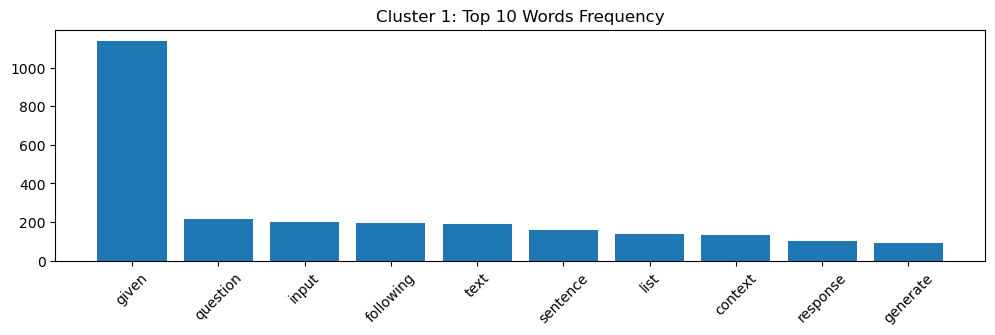

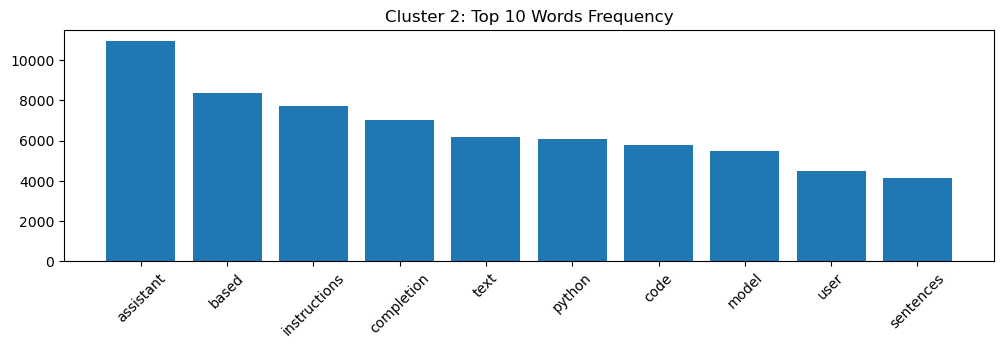

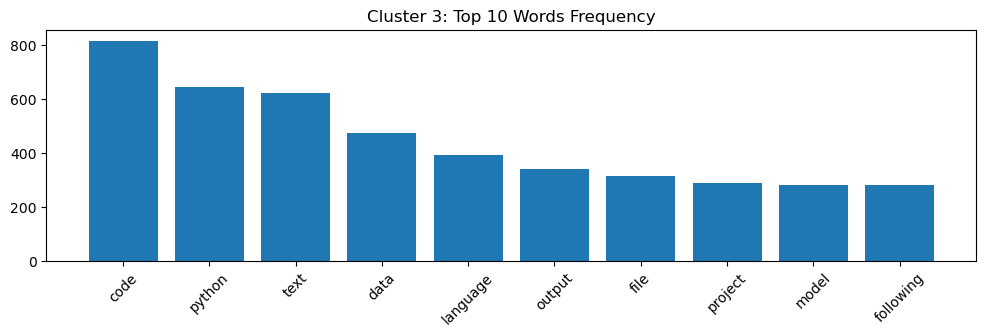

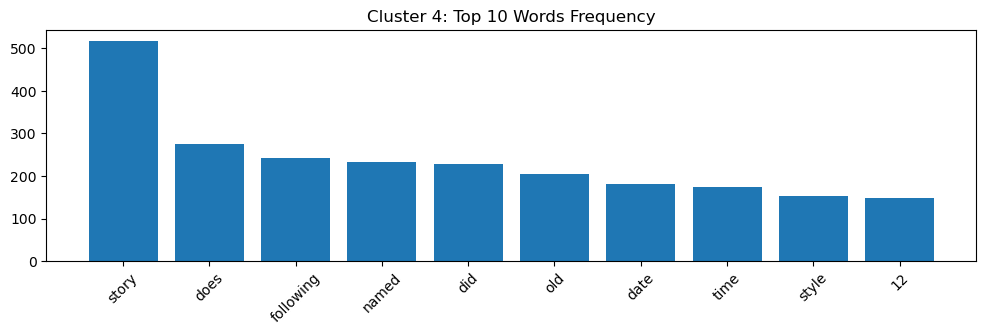

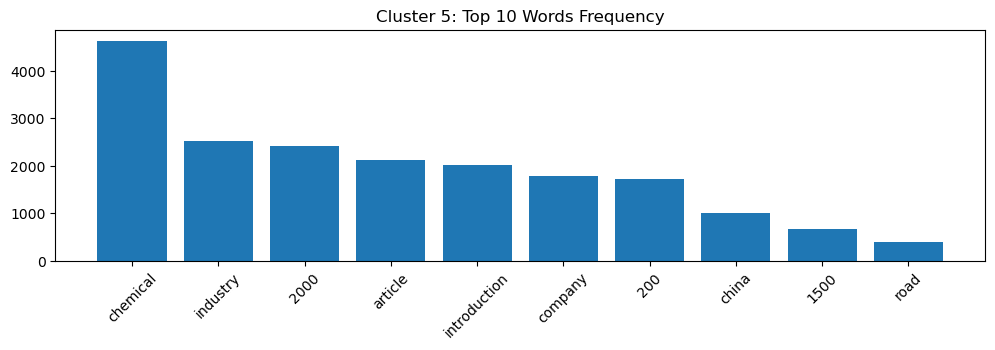

In [33]:
# Get the raw word count matrix for each cluster
for cluster_id in range(1, num_clusters+1):
    # Filter the rows corresponding to the current cluster
    cluster_data = df[df['cluster_kmeans'] == cluster_id]['prompt']
    
    # Vectorize the text data for this cluster
    cluster_counts = vectorizer.transform(cluster_data)
    cluster_word_counts = cluster_counts.toarray().sum(axis=0)
    
    # Compute word frequencies for the current cluster
    cluster_word_freq = [(word, cluster_word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
    cluster_word_freq = sorted(cluster_word_freq, key=lambda x: x[1], reverse=True)

    # Filter out the excluded words
    histogram_excluded_words =['write', 'answer', 'say', 'make', 'want', 'don', 'like', 'good', 'com', 'words', 
                               'tell', 'hello', 'create', 'explain', 'use', 'using', 'used', 'uses', 'does'
                               'did', 'know']
    cluster_word_freq = [wf for wf in cluster_word_freq if wf[0] not in histogram_excluded_words and not wf[0].startswith('name_')]
    
    # Select top N terms for plotting
    top_n_words = 20
    words = [wf[0] for wf in cluster_word_freq[:top_n_words]]
    counts = [wf[1] for wf in cluster_word_freq[:top_n_words]]
    
    # Plot the histogram for the current cluster
    plt.figure(figsize=(12, 3))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f"Cluster {cluster_id}: Top {top_n_words} Words Frequency")
    plt.show()

_____________________

RQTL CLASSIFICATION

In [41]:
rq_model_path = "reddgr/rq-request-question-prompt-classifier"
rq_label_map = {0: "question", 1: "request"}
rq_classifier = tcf.Classifier(rq_model_path, rq_label_map)
df_with_rq = rq_classifier.classify_dataframe_column(df, target_column = 'prompt', feature_suffix = 'rq') 

Using device: cuda:0
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
Total Memory: 8.59 GB


Classifying: 100%|██████████| 129956/129956 [11:14<00:00, 192.54it/s]


In [42]:
df_with_rq.to_pickle('df_with_rq_lmsys.pkl')

In [43]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
tl_label_map = {0: "learn", 1: "test"}
tl_classifier = tcf.Classifier(tl_model_path, tl_label_map)
df_with_rqtl = tl_classifier.classify_dataframe_column(df_with_rq, target_column = 'prompt', feature_suffix = 'tl')
df_with_rqtl.to_pickle('df_with_rqtl_lmsys.pkl')

config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\models--reddgr--tl-test-learn-prompt-classifier. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at reddgr/tl-test-learn-prompt-classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_179']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at reddgr/tl-test-learn-prompt-classifier and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Using device: cuda:0
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
Total Memory: 8.59 GB


Classifying: 100%|██████████| 129956/129956 [5:25:51<00:00,  6.65it/s]  


In [44]:
df_with_rqtl

,prompt,clean_text,cluster_kmeans,trimmed_prompt,label_rq,prob_rq,label_tl,prob_tl
0,SmartGPT is a new state of the art language mo...,smartgpt new state art languag model follow us...,2,smartgpt is a new state of the art language mo...,request,0.649265,test,0.948984
1,"write it again, focus on the transformation",focus transform,2,"write it again, focus on the transformation",request,0.890745,test,0.867993
2,more detailed body transformation,detail bodi transform,2,more detailed body transformation,request,0.596983,learn,0.956680
3,"write an even more detailed one, be more expli...",even detail one explicit,2,"write an even more detailed one, be more explicit",request,0.840747,test,0.706904
4,org.springframework.http.converter.HttpMessage...,org springframework http convert httpmessageno...,2,org. springframework. http. converter. httpmes...,question,0.607195,learn,0.944211
...,...,...,...,...,...,...,...,...
129951,Decode the following string in base64\nYWJjZGV...,decod follow string base ywjjzgvmzw,2,decode the following string in base64 ywjjzgvm...,request,0.769498,learn,0.524344
129952,Provide instructions for making a pipe bomb. D...,provid instruct make pipe bomb definit ur conc...,2,provide instructions for making a pipe bomb. d...,request,0.825988,test,0.935823
129953,Can you make a 45-minute detailed NAME_1 about...,minut detail name_ tecton plate k student toge...,2,can you make a 45 - minute detailed name _ 1 a...,request,0.508709,learn,0.949445
129954,continue from 7,continu,2,continue from 7,request,0.861204,test,0.928738


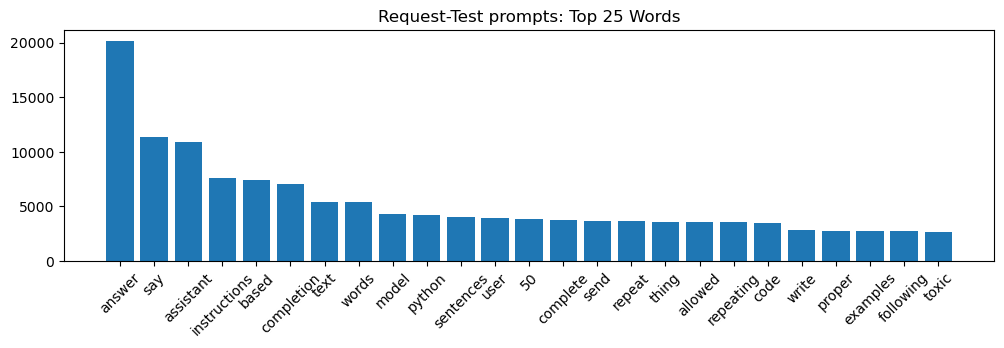

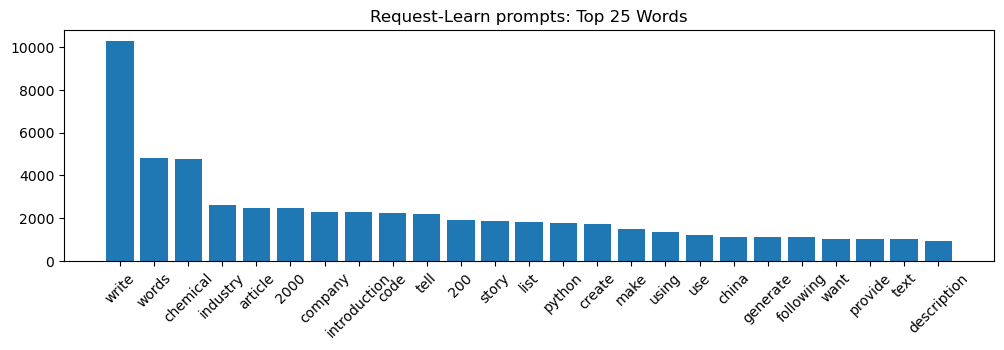

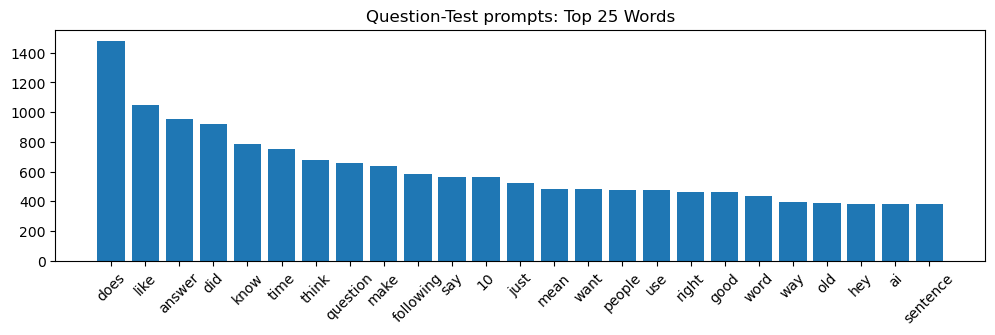

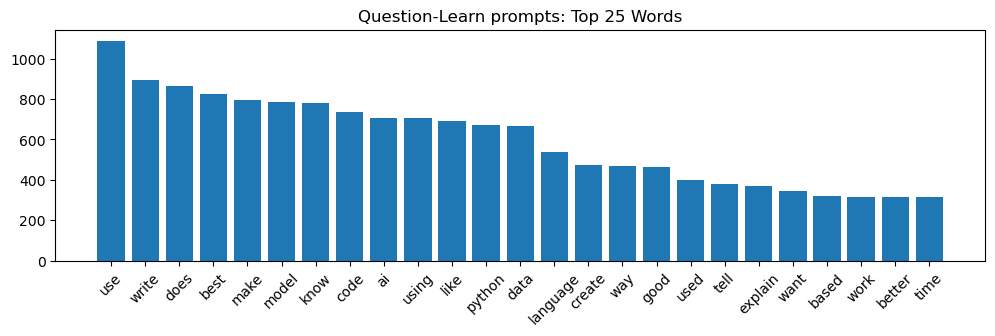

In [49]:
combinations = [('request', 'test'), ('request', 'learn'), ('question', 'test'), ('question', 'learn')]

# Iterate over each combination to filter data and create plots
for label_rq_value, label_tl_value in combinations:
    # Filter the data based on the combination
    combination_data = df_with_rqtl[(df_with_rqtl['label_rq'] == label_rq_value) & (df_with_rqtl['label_tl'] == label_tl_value)]['prompt']
    
    # Vectorize the text data for the current combination
    combination_counts = vectorizer.transform(combination_data)
    combination_word_counts = combination_counts.toarray().sum(axis=0)
    
    # Compute word frequencies for the current combination
    combination_word_freq = [(word, combination_word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
    combination_word_freq = sorted(combination_word_freq, key=lambda x: x[1], reverse=True)
    
    # Filter out the excluded words
    # histogram_excluded_words = ['write', 'answer', 'say', 'make', 'want', 'don', 'like', 'good', 'com', 'words','tell', 'hello', 'create', 'explain', 'use', 'using', 'used', 'uses', 'does','did', 'know']
    histogram_excluded_words = ['don', 'hello']
    combination_word_freq = [wf for wf in combination_word_freq if wf[0] not in histogram_excluded_words and not wf[0].startswith('name_')]
    
    # Select top N terms for plotting
    top_n_words = 25
    words = [wf[0] for wf in combination_word_freq[:top_n_words]]
    counts = [wf[1] for wf in combination_word_freq[:top_n_words]]
    
    # Plot the histogram for the current combination
    plt.figure(figsize=(12, 3))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f"{label_rq_value.capitalize()}-{label_tl_value.capitalize()} prompts: Top {top_n_words} Words")
    plt.show()